<a href="https://colab.research.google.com/github/blcrivellaro/api_remove_background_autoencoder/blob/main/modelo_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Monta o google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
# Renomeia diretorio para mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [4]:
import os
import shutil
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Input

%matplotlib inline

In [ ]:
# Caminho das pastas no google drive
pasta_dirty = '/mydrive/data/1.dirty'
pasta_clean = '/mydrive/data/2.cleaned_example'
pasta_test = '/mydrive/data/3.dirty_test'

#Cria uma nova pasta para armazenar imagens para teste do modelo e move as imagens para a mesma
os.mkdir(pasta_test)
for image in os.listdir(pasta_dirty):
  if image not in os.listdir(pasta_clean):
    shutil.move(os.path.join(pasta_dirty, image), pasta_test)

In [6]:
# Funcao para processamento das imagens
def process_img(path_img):
    img = cv.imread(path_img)
    img = cv.resize(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (540, 420))
    img = np.reshape(np.asarray(img/255.0, dtype="float32"), (420, 540, 1))
    
    return img

In [7]:
# Lista de imagens para treinamento e testes
train_clean = []
train_dirty = []
test_dirty = []

for image in sorted(os.listdir(pasta_dirty)):
     path_image_dirty = os.path.join(pasta_dirty, image)
     path_image_clean = os.path.join(pasta_clean, image)

     train_clean.append(process_img(path_image_clean))
     train_dirty.append(process_img(path_image_dirty))

for image_test in sorted(os.listdir(pasta_test)):
     path_image_test = os.path.join(pasta_test, image_test)
     
     test_dirty.append(process_img(path_image_test))

print('Número de imagens dirty para o processo de treinamento:', len(train_dirty))
print('Número de imagens clean para o processo de treinamento:', len(train_clean))
print('Número de imagens dirty para teste:', len(test_dirty))

Número de imagens dirty para o processo de treinamento: 144
Número de imagens clean para o processo de treinamento: 144
Número de imagens dirty para teste: 72


In [8]:
# Converte as listas em arrays e separa imagens para o processo de treinamento em treino e validacao
X_train = np.asarray(train_dirty)
Y_train = np.asarray(train_clean)
X_test = np.asarray(test_dirty)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)
print("Número de imagens para treinamento: ", X_train.shape[0])
print("Número de imagens para validacao: ", X_val.shape[0])

Número de imagens para treinamento:  122
Número de imagens para validacao:  22


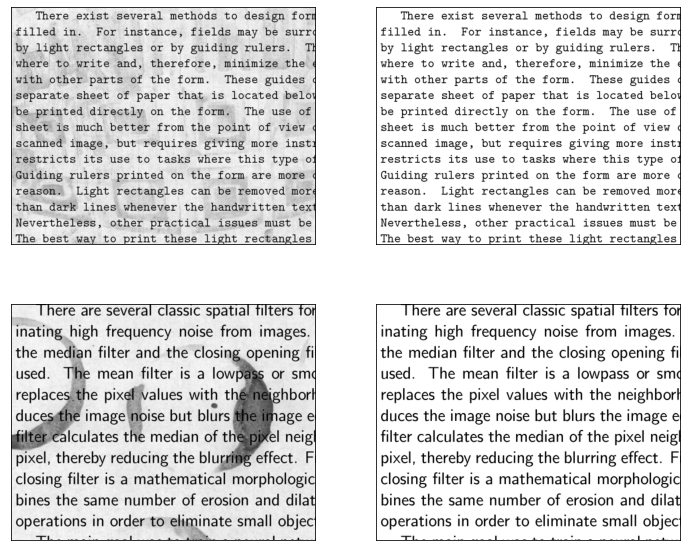

In [27]:
# Exemplos de imagens (dirty/clean) utilizadas para treinamento do modelo autoencoder
os.mkdir('/mydrive/imgs')

x = 1
plt.figure(figsize=(12, 10))
for xt in range(len(X_train)):
    if xt == 5 or xt == 120: 
      plt.subplot(2,2,x)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_train[xt][:,:,0], cmap='gray')

      plt.subplot(2,2,x+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(Y_train[xt][:,:,0], cmap='gray')

      x +=2

plt.savefig('/mydrive/imgs/exemplos_imagens_treinamento.png')
plt.show()


In [18]:
def autoencoder():
    input_img = Input(shape=(420,540,1))
    
    # Encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)
    
    #Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
    # Modelo
    model = Model(inputs=input_img, outputs=decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Treinamento do modelo para remocao de background utilizando autoencoder
model = autoencoder()
treinamento = model.fit(X_train, Y_train, epochs=500, batch_size=24, validation_data=(X_val, Y_val))

In [ ]:
# Salvar modelo
os.mkdir('/mydrive/model')
model.save('/mydrive/model')

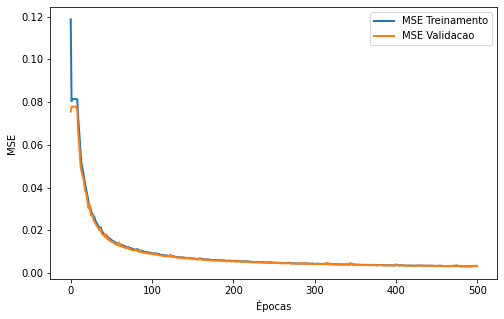

In [36]:
# Erro médio quadrático (MSE) X Épocas
erro_treinamento = treinamento.history['loss']
erro_validacao = treinamento.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(range(0,len(erro_treinamento)), erro_treinamento, linewidth=2, label='MSE Treinamento')
plt.plot(range(0,len(erro_validacao)), erro_validacao, linewidth=2, label='MSE Validacao')
plt.legend(loc='best')

#plt.xlim(0, 500)
#plt.ylim(-0.01, 0.15)
plt.xlabel('Épocas')
plt.ylabel('MSE')

plt.savefig('/mydrive/imgs/loss_mse_treinamento.png')
plt.show()


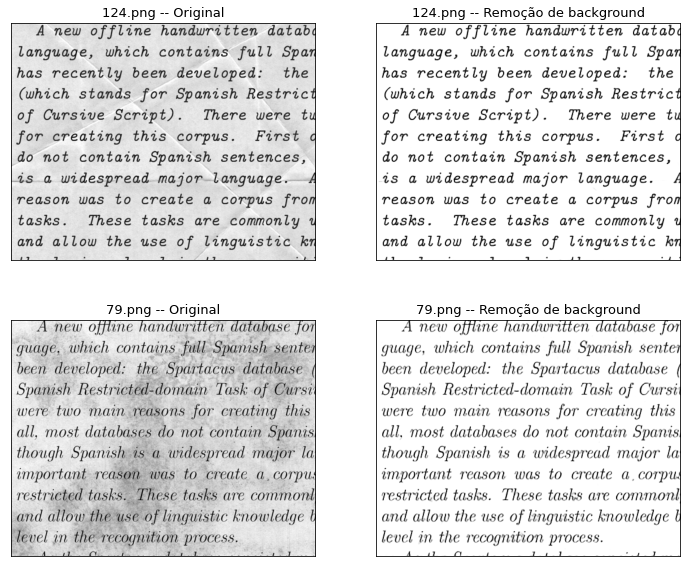

In [35]:
# Teste modelo autoencoder para remoção de background
Y_test = model.predict(X_test)

names_images_test = sorted(os.listdir(pasta_test))

i = 1
plt.figure(figsize=(12,10))
for ni, name_image in enumerate(names_images_test):
    if ni == 10 or ni == 65: 
      plt.subplot(2,2,i)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[ni][:,:,0], cmap='gray')
      plt.title('{} -- Original'.format(name_image),fontsize=13)
    
      plt.subplot(2,2,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(Y_test[ni][:,:,0], cmap='gray')
      plt.title('{} -- Remoção de background'.format(name_image),fontsize=13)

      i +=2

plt.savefig('/mydrive/imgs/exemplos_imagens_teste.png')
plt.show()
